C:\Users\koishikawa\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Bayesian optimization iteration : 1 / 2
Best score : 0.23450785875320435
Bayesian optimization iteration : 2 / 2
Best score : 0.23450785875320435


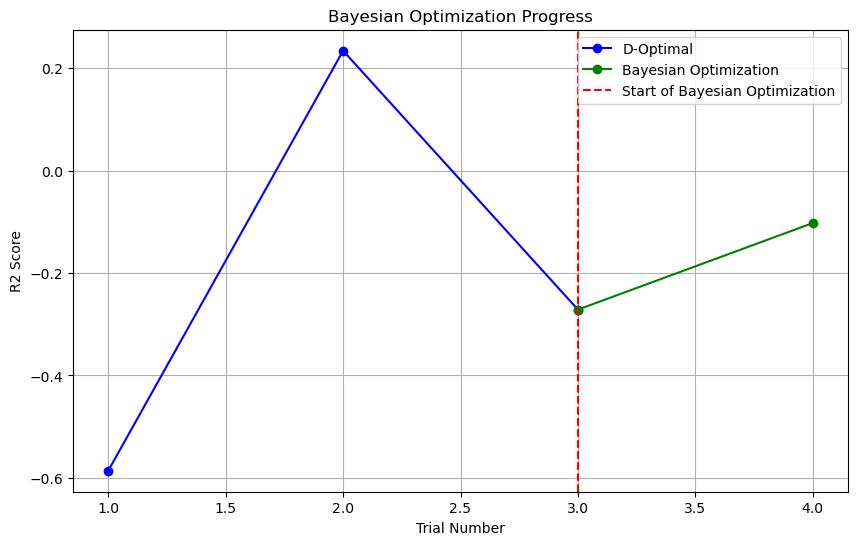

In [1]:
import pandas as pd
from bo_lstm_multiple_acquisition_function import bo_lstm_hyperparams
from sklearn.model_selection import train_test_split
#データセットの読み込み
dataset = pd.read_csv('sample_dataset.csv', index_col=0)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, shuffle=False)

(model, optimal_window_size, optimal_batch_size, optimal_learning_rate) = bo_lstm_hyperparams(train_dataset,num_epochs =10, 
                                                                                              bo_iteration_number=2, display_flag=True, bo_iteration_plot=True)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

seq_length = int(optimal_window_size)
hidden_dim = int(optimal_hidden_dim)
output_dim = 1
batch_size = int(optimal_batch_size)
num_epochs = 100
use_attention = optimal_attention  # Attention層を使うかどうかを選択 (True or False)
fold_number = 5  # N-fold CV の N


# -------------------------------
# データ読み込みと前処理（変更なし）
# -------------------------------

dataset = pd.read_csv('sample_dataset.csv', index_col=0)

data = dataset.values.astype('float32')

inputs = data[:, 1:]
targets = data[:, 0]

#ここで入力の次元が決まります
input_dim = dataset.shape[1] - 1

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(xs), np.array(ys)

input_sequences, target_sequences = create_sequences(inputs, targets, seq_length)

X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, target_sequences, test_size=0.3, shuffle=False)

train_inputs_tensor = torch.tensor(X_train).float()
train_targets_tensor = torch.tensor(y_train).float().unsqueeze(1)

test_inputs_tensor = torch.tensor(X_test).float()
test_targets_tensor = torch.tensor(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(train_inputs_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = LSTMWithOptionalAttention(input_dim, hidden_dim, output_dim, use_attention, optimal_dropout_rate)

# -------------------------------
# 学習準備（変更なし）
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=optimal_learning_rate)

# -------------------------------
# モデル学習（Attentionの重みは必要に応じて取得）
# -------------------------------
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# -------------------------------
# モデル評価（Attentionの重みは必要に応じて保存）
# -------------------------------
model.eval()
test_loss = 0
all_test_predictions = []
all_true_test_targets = []
all_attention_weights = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, attention_weights = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_true_test_targets.extend(targets.cpu().numpy().flatten())
        if use_attention:
            all_attention_weights.extend(attention_weights.cpu().numpy())

average_test_loss = test_loss / len(test_dataset)
r2 = r2_score(all_true_test_targets, all_test_predictions)
#r2 = r2lm(all_true_test_targets, all_test_predictions)
mae = mean_absolute_error(all_true_test_targets, all_test_predictions)
rmse = np.sqrt(mean_squared_error(all_true_test_targets, all_test_predictions))

print(f'\n平均テスト損失: {average_test_loss:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# -------------------------------
# プロット
# -------------------------------
# 学習曲線（変更なし）
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# テスト結果（変更なし）
plt.figure(figsize=(12, 6))
plt.plot(all_true_test_targets, label='Actual')
plt.plot(all_test_predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model

LSTMWithOptionalAttention(
  (lstm): LSTM(6, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): Attention(
    (attn_proj): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Bayesian optimization iteration : 1 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 2 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 3 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 4 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 5 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 6 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 7 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 8 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 9 / 30
Best score : -91.5982453004732
Bayesian optimization iteration : 10 / 30
Best score : -73.46566038365198
Bayesian optimization iteration : 11 / 30
Best score : -73.46566038365198
Bayesian optimization iteration : 12 / 30
Best score : -73.46566038365198
Bayesian optimization iteration : 13 / 30
Best score : -73.46566038365198
Bayesian optimization iteration : 14 / 30
Best score : -

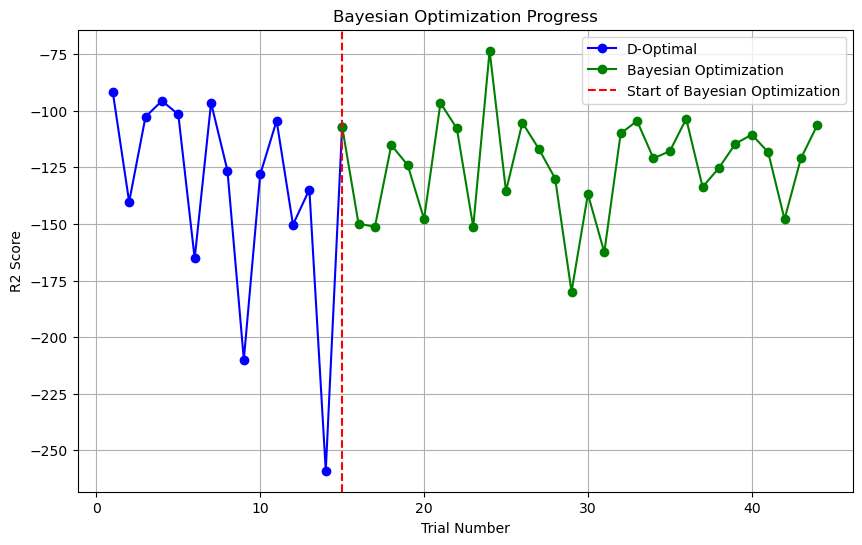

Epoch [1/100], Loss: 0.0612
Epoch [2/100], Loss: 0.0361
Epoch [3/100], Loss: 0.0326
Epoch [4/100], Loss: 0.0337
Epoch [5/100], Loss: 0.0330
Epoch [6/100], Loss: 0.0304
Epoch [7/100], Loss: 0.0299
Epoch [8/100], Loss: 0.0287
Epoch [9/100], Loss: 0.0282
Epoch [10/100], Loss: 0.0281
Epoch [11/100], Loss: 0.0273
Epoch [12/100], Loss: 0.0271
Epoch [13/100], Loss: 0.0270
Epoch [14/100], Loss: 0.0260
Epoch [15/100], Loss: 0.0266
Epoch [16/100], Loss: 0.0258
Epoch [17/100], Loss: 0.0252
Epoch [18/100], Loss: 0.0240
Epoch [19/100], Loss: 0.0238
Epoch [20/100], Loss: 0.0230
Epoch [21/100], Loss: 0.0229
Epoch [22/100], Loss: 0.0214
Epoch [23/100], Loss: 0.0213
Epoch [24/100], Loss: 0.0191
Epoch [25/100], Loss: 0.0186
Epoch [26/100], Loss: 0.0159
Epoch [27/100], Loss: 0.0152
Epoch [28/100], Loss: 0.0145
Epoch [29/100], Loss: 0.0138
Epoch [30/100], Loss: 0.0132
Epoch [31/100], Loss: 0.0131
Epoch [32/100], Loss: 0.0116
Epoch [33/100], Loss: 0.0122
Epoch [34/100], Loss: 0.0104
Epoch [35/100], Loss: 0

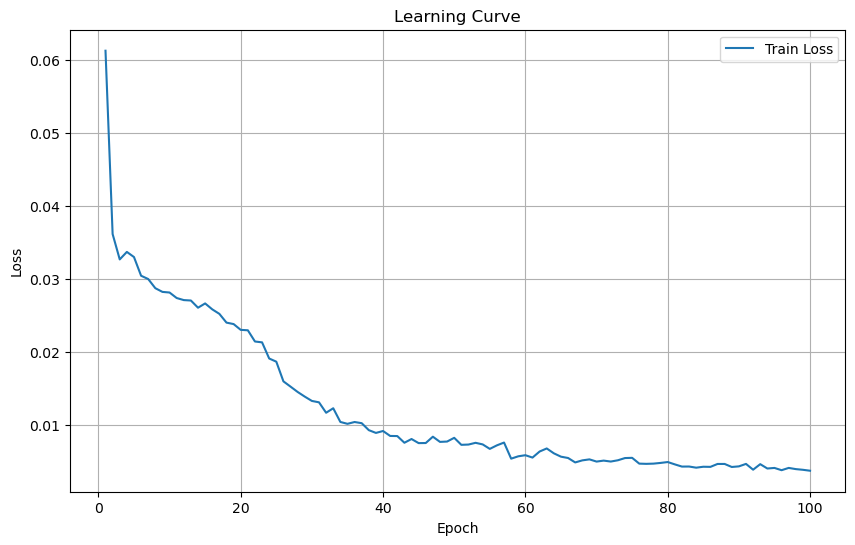

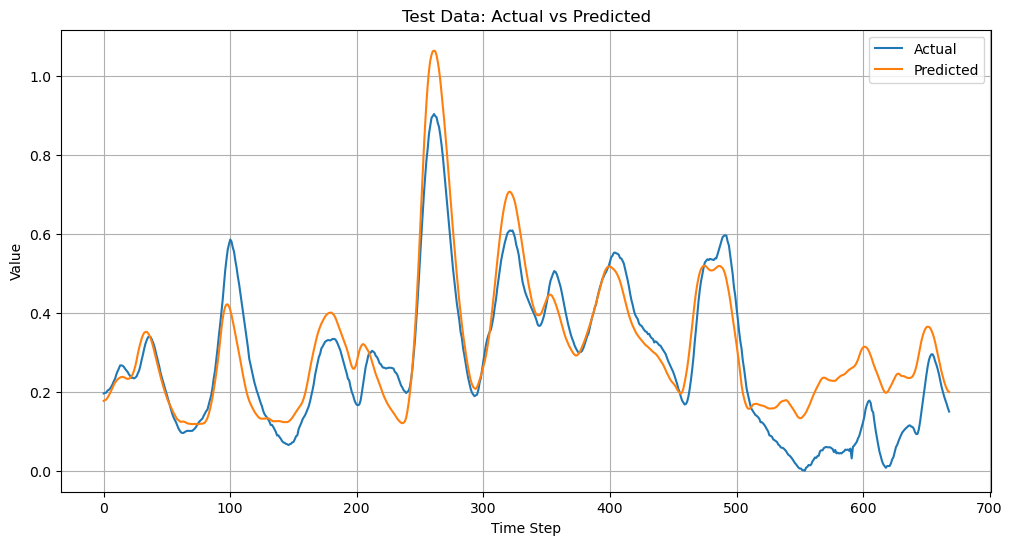

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 外部ファイルから必要な関数をインポート (修正)
from bo_lstm_multiple_acquisition_function import bo_lstm_hyperparams, r2lm  # 適切なパスに修正

# データセットの読み込み
try:
    dataset = pd.read_csv('sample_dataset.csv', index_col=0)
except FileNotFoundError:
    print("エラー：'sample_dataset.csv' が見つかりません。ファイルパスを確認してください。")
    exit()

# データの分割
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, shuffle=False)

# ハイパーパラメータの最適化
(model, optimal_window_size, optimal_batch_size, optimal_learning_rate) = bo_lstm_hyperparams(
    train_dataset,
    num_epochs=100,
    bo_iteration_number=30,
    display_flag=True,
    bo_iteration_plot=True
)

# -------------------------------
# 学習準備
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=optimal_learning_rate)

# データローダーの作成 (追加)
def create_data_loader(dataset, window_size, batch_size, shuffle=True):
    """
    時系列データをLSTMモデルに入力するためのデータローダーを作成します。

    Args:
        dataset (pd.DataFrame): 入力データセット。
        window_size (int): 入力シーケンスの長さ。
        batch_size (int): バッチサイズ。
        shuffle (bool): データをシャッフルするかどうか。

    Returns:
        torch.utils.data.DataLoader: データローダー。
    """
    data = dataset.values
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size, 1:])  # 説明変数のみを使用
        targets.append(data[i+window_size, 0])    # 目的変数のみを使用
    sequences = torch.FloatTensor(sequences)
    targets = torch.FloatTensor(targets)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

train_loader = create_data_loader(train_dataset, optimal_window_size, optimal_batch_size, shuffle=False)
test_loader = create_data_loader(test_dataset, optimal_window_size, optimal_batch_size, shuffle=False)


num_epochs = 100 #bo_lstm_hyperparams内で定義されているが、明示的に定義
use_attention = hasattr(model, 'attention_weights') # モデルがattentionを持つかどうかを確認

# -------------------------------
# モデル学習
# -------------------------------
train_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)  # attention_weightsを受け取るように修正
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)  # train_loaderを使うように修正
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# -------------------------------
# モデル評価
# -------------------------------
model.eval()
test_loss = 0
all_test_predictions = []
all_true_test_targets = []
all_attention_weights = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, attention_weights = model(inputs)  # attention_weightsを受け取る
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_true_test_targets.extend(targets.cpu().numpy().flatten())
        if use_attention:
            all_attention_weights.extend(attention_weights.cpu().numpy())

average_test_loss = test_loss / len(test_loader.dataset) # test_loaderを使うように修正
#r2 = r2_score(all_true_test_targets, all_test_predictions)
r2 = r2lm(all_true_test_targets, all_test_predictions)
mae = mean_absolute_error(all_true_test_targets, all_test_predictions)
rmse = np.sqrt(mean_squared_error(all_true_test_targets, all_test_predictions))

print(f'\n平均テスト損失: {average_test_loss:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# -------------------------------
# プロット
# -------------------------------
# 学習曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# テスト結果
plt.figure(figsize=(12, 6))
plt.plot(all_true_test_targets, label='Actual')
plt.plot(all_test_predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

if use_attention:
    # Attentionの重みの可視化 (例として最初のテストサンプルのみ)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.array(all_attention_weights[0]), cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Attention Weights (First Test Sample)')
    plt.xlabel('Input Time Step')
    plt.ylabel('Output Time Step')
    plt.show()


In [7]:
model
#print(optimal_window_size, optimal_batch_size, optimal_learning_rate)

LSTMModel(
  (lstm): LSTM(7, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

Epoch [1/100], Loss: 0.0221
Epoch [2/100], Loss: 0.0202
Epoch [3/100], Loss: 0.0191
Epoch [4/100], Loss: 0.0181
Epoch [5/100], Loss: 0.0171
Epoch [6/100], Loss: 0.0159
Epoch [7/100], Loss: 0.0138
Epoch [8/100], Loss: 0.0118
Epoch [9/100], Loss: 0.0109
Epoch [10/100], Loss: 0.0104
Epoch [11/100], Loss: 0.0103
Epoch [12/100], Loss: 0.0098
Epoch [13/100], Loss: 0.0099
Epoch [14/100], Loss: 0.0097
Epoch [15/100], Loss: 0.0090
Epoch [16/100], Loss: 0.0092
Epoch [17/100], Loss: 0.0093
Epoch [18/100], Loss: 0.0093
Epoch [19/100], Loss: 0.0087
Epoch [20/100], Loss: 0.0086
Epoch [21/100], Loss: 0.0087
Epoch [22/100], Loss: 0.0088
Epoch [23/100], Loss: 0.0091
Epoch [24/100], Loss: 0.0083
Epoch [25/100], Loss: 0.0083
Epoch [26/100], Loss: 0.0085
Epoch [27/100], Loss: 0.0082
Epoch [28/100], Loss: 0.0082
Epoch [29/100], Loss: 0.0080
Epoch [30/100], Loss: 0.0081
Epoch [31/100], Loss: 0.0081
Epoch [32/100], Loss: 0.0083
Epoch [33/100], Loss: 0.0081
Epoch [34/100], Loss: 0.0082
Epoch [35/100], Loss: 0

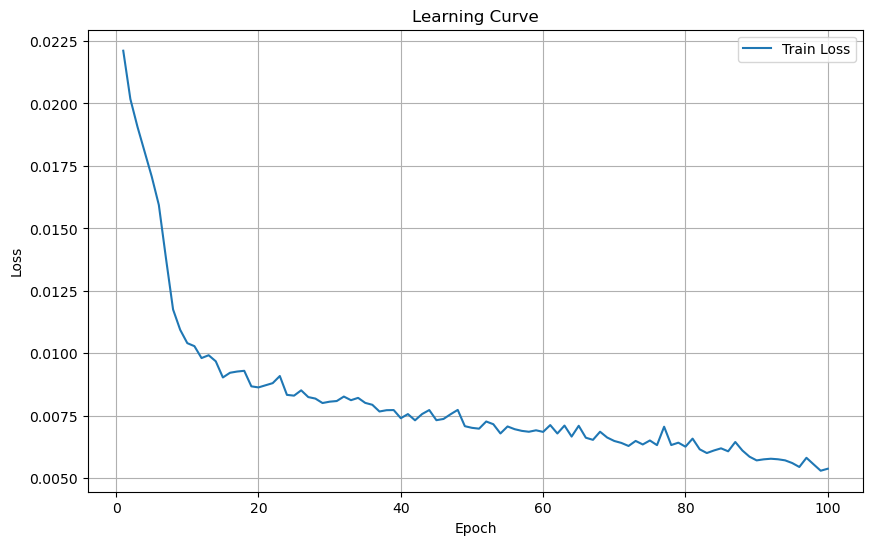

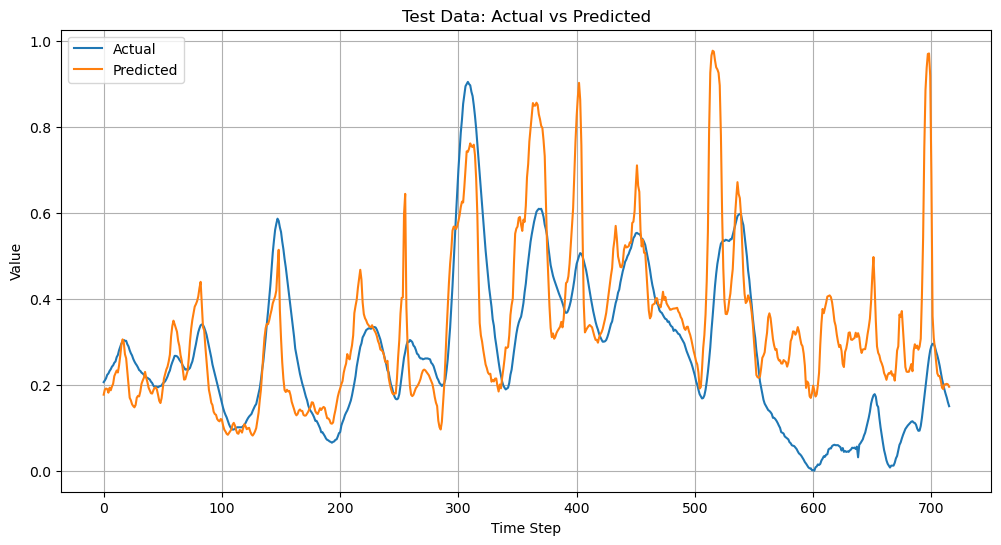

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ハイパーパラメータ（変更なし）
seq_length = 10
input_dim = 7
hidden_dim = 8
output_dim = 1
batch_size = 16
num_epochs = 100

# -------------------------------
# データ読み込みと前処理
# -------------------------------
dataset = pd.read_csv('sample_dataset.csv', index_col=0)
data = dataset.values.astype('float32')

# 説明変数と目的変数に分離
inputs = data[:, 1:]  # 説明変数（列2〜6）
targets = data[:, 0]  # 目的変数（列1）

# 時系列ウィンドウを作成
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(xs), np.array(ys)

input_sequences, target_sequences = create_sequences(inputs, targets, seq_length)

# 学習・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, target_sequences, test_size=0.3, shuffle=False)

# PyTorchテンソルに変換
train_inputs_tensor = torch.tensor(X_train).float()
train_targets_tensor = torch.tensor(y_train).float().unsqueeze(1)

test_inputs_tensor = torch.tensor(X_test).float()
test_targets_tensor = torch.tensor(y_test).float().unsqueeze(1)

# TensorDatasetの作成
train_dataset = TensorDataset(train_inputs_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# LSTMモデルの定義
# -------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 最後の時点の出力を使う
        out = self.fc(out)
        return out

model = LSTMModel(input_dim, hidden_dim, output_dim)

# -------------------------------
# 学習準備
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# -------------------------------
# モデル学習
# -------------------------------
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# -------------------------------
# モデル評価
# -------------------------------
model.eval()
test_loss = 0
all_test_predictions = []
all_true_test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_true_test_targets.extend(targets.cpu().numpy().flatten())

# 指標計算
average_test_loss = test_loss / len(test_dataset)
#r2 = r2_score(all_true_test_targets, all_test_predictions)
r2 = r2lm(all_true_test_targets, all_test_predictions)
mae = mean_absolute_error(all_true_test_targets, all_test_predictions)
rmse = np.sqrt(mean_squared_error(all_true_test_targets, all_test_predictions))

print(f'\n平均テスト損失: {average_test_loss:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# -------------------------------
# プロット
# -------------------------------
# 学習曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# テスト結果
plt.figure(figsize=(12, 6))
plt.plot(all_true_test_targets, label='Actual')
plt.plot(all_test_predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()